# 04. PyTorch Custom Datasets

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: this notebook required torch >= 1.10.0
torch.__version__

'2.0.1+cu117'

In [2]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get data

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory exists.')
else:
    print(f'Did not find {image_path} directory, creating one...')
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
        print('Downloading pizza, steak, sushi data...')
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
        print('Unzipping pizza, steak, sushi data...')
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


## 2. Become one with the data (data preparation)

In [4]:
import os
def walk_through_dir(dir_path):
    """
    Walks through dir_path, retruning its contents.
    Args:
        dir_path (str or pathlib.Path): target directory

    Returns:
        A print out of:
            number of subdirectories in dir_path
            number of images (files) in each subdirectory
            name of each subdirectory
    """
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [6]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

Random image path: data/pizza_steak_sushi/train/pizza/1654444.jpg
Image class: pizza
Image height: 289
Image width: 512


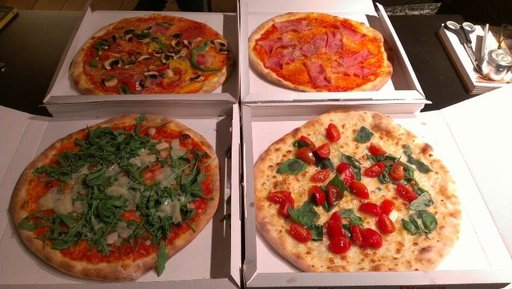

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens #* different image!

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')
img

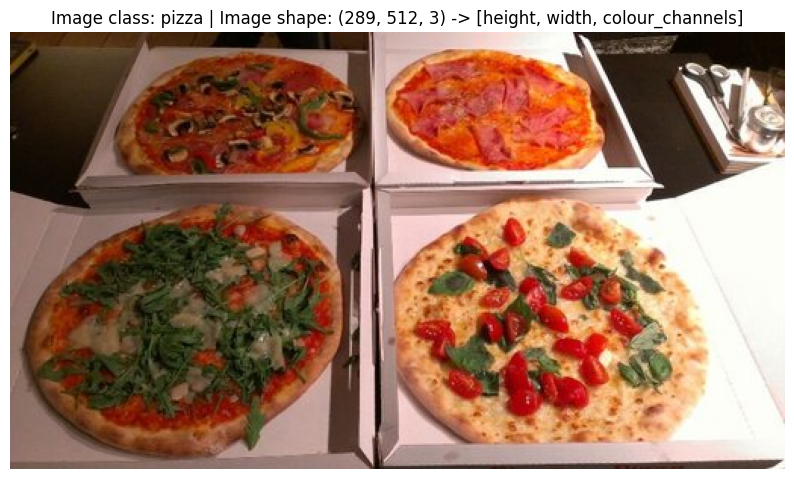

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, colour_channels]')
plt.axis(False);

### 3. Transforming data

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [10]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

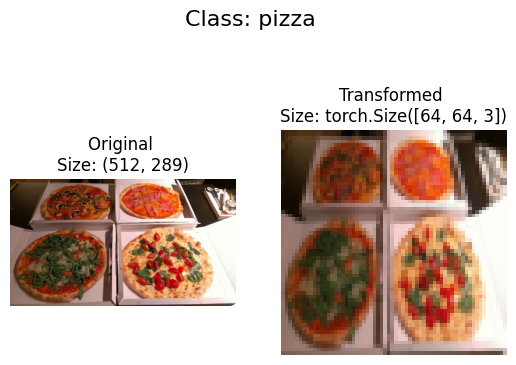

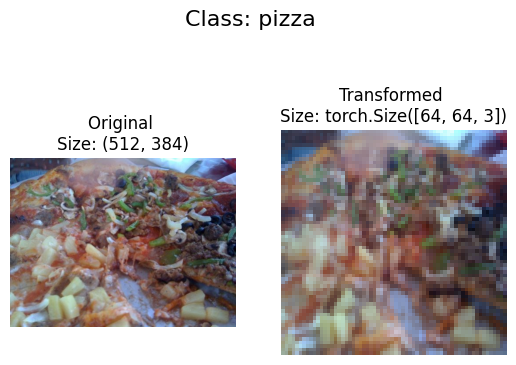

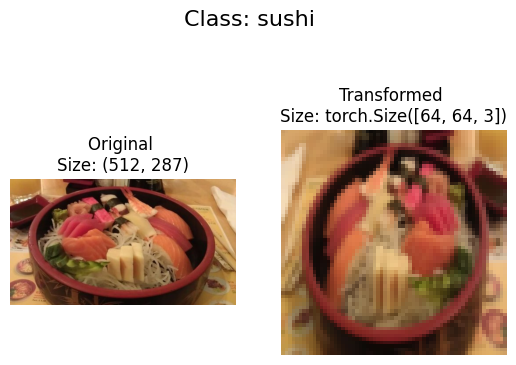

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """
    Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transfrom and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for therandom generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_path = random.sample(image_paths, k=n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fg, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original \nSize: {f.size}')
            ax[0].axis('off')

            # Transform and plot image
            # Note: permute() will change shape of image to suit Matplotlib
            # (PyTorch default is [C, H, W] by Matplotlib is [H, W, C]) #* WHYYYYYY
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed \nSize: {transformed_image.shape}')
            ax[1].axis('off')

            fg.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Option 1: Loading Image Data Using `ImageFolder`

In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,           # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None)    # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f'Train data:\n{train_data}\nTest data:\n{test_data}')

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Testdata:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor:\n{img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [colour_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, colour_channels]


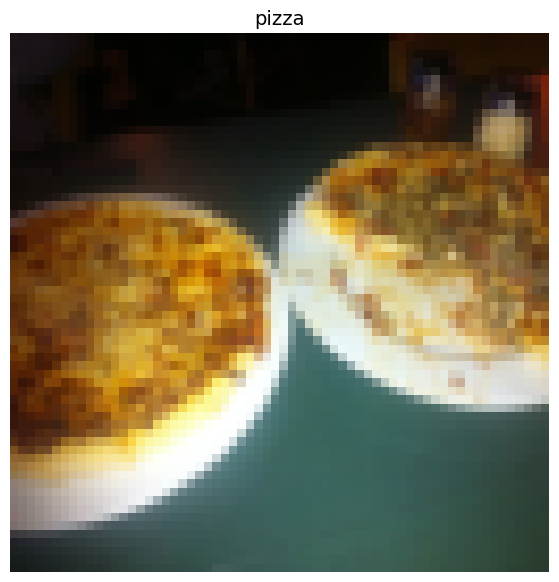

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f'Original shape: {img.shape} -> [colour_channels, height, width]')
print(f'Image permute shape: {img_permute.shape} -> [height, width, colour_channels]')

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into `DataLoader`'s

In [18]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,  # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True)  # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)  # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f5cf01e5850>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5cf01edb90>)

In [19]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f'Image shape: {img.shape} -> [batch_size, color_channels, height, width]')
print(f'Label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

In [20]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [21]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [22]:
# Setup path for target directory
target_directory = train_dir
print(f'Target directory: {target_directory}')

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / 'train'))])
print(f'Class names found: {class_names_found}')

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [23]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """
    Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes('food_images/train')
        >>> (['class_1', 'class_2'], {'class_1': 0, ...})
    """

    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [24]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [25]:
# Write a custom dataset class (inherits from troch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg')) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int)-> Image.Image:
        """Opens an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        """Returns the total number of samples."""
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X, y)."""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [26]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [27]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f5cf007b790>,
 <__main__.ImageFolderCustom at 0x7f5cf0029510>)

In [28]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [29]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [30]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [31]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

In [32]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indices
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, heigh, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f'class: {classes[targ_label]}'
            if display_shape:
                title = title + f'\nshape: {targ_image_adjust.shape}'
        plt.title(title)

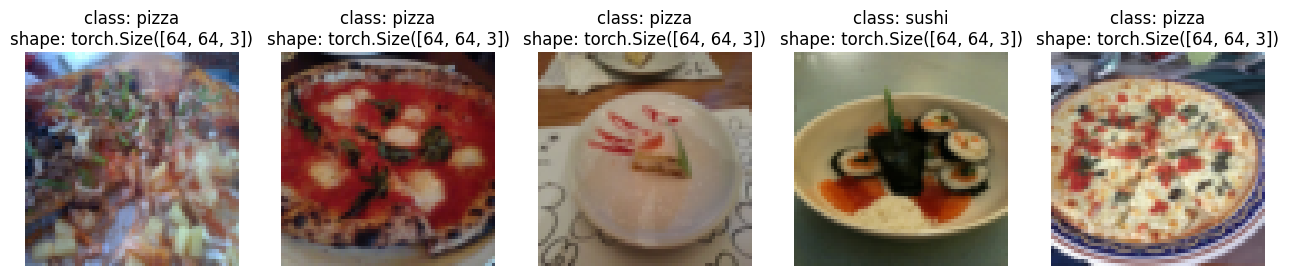

In [33]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


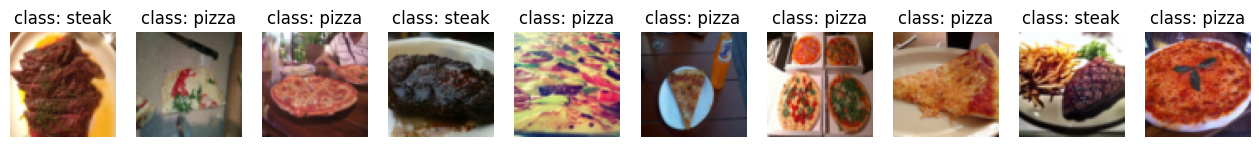

In [34]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=42) # Try setting the seed for reproducible images

### 5.4 Turn custom loaded images into `DataLoader`s

In [35]:
# Turn train and test custom Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1,              # how many samples per batch?
                                     num_workers=0,             # how many subprocesses to use for data laoding? (higher = more)
                                     shuffle=True)              # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created Dataset
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)            # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom      

(<torch.utils.data.dataloader.DataLoader at 0x7f5cf01e5990>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5d1dbbc8d0>)

In [36]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f'Image shape: {img_custom.shape} -> [batch_size, color_channels. height, width]')
print(f'Label shape: {label_custom.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels. height, width]
Label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)

In [37]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

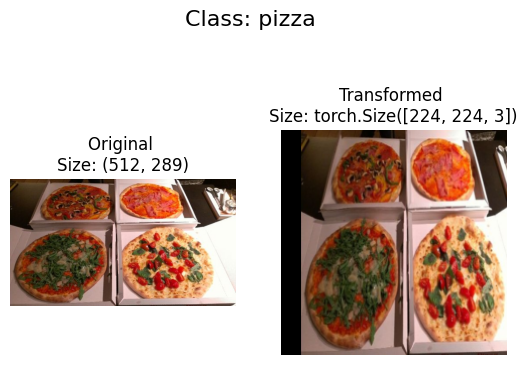

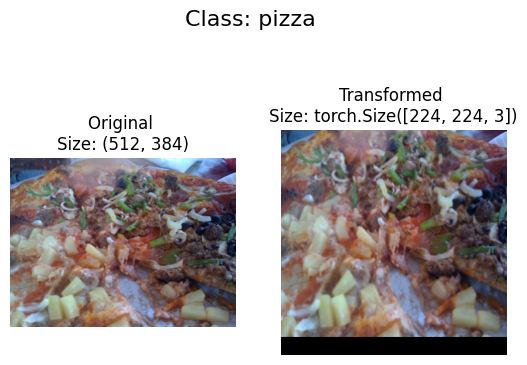

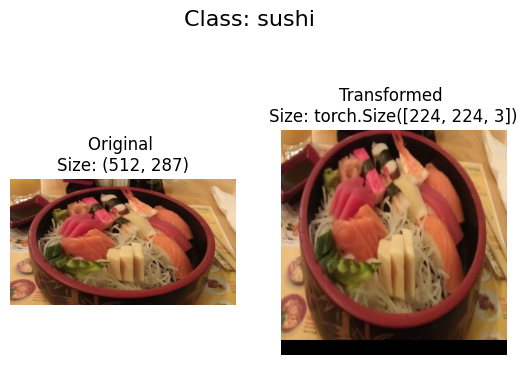

In [38]:
# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=42
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transfornms and loading data for Model 0

In [39]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [40]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple = DataLoader(test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 12 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7f5d1d76df50>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5d1d76edd0>)

### 7.2 Create TinyVGG model class

In [41]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1,      # default
                      padding=1),    # options = 'valid' (no padding) or 'same' (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size 
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits fo operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of colour channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [42]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batc hand unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f'Single image shape: {img_single.shape}\n')

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what;s happening and convert model logits -> pred probs -> pred label
print(f'Output logits:\n{pred}\n')
print(f'Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n')
print(f'Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n')
print(f'Actual label:\n{label_single}')

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0603, 0.0605, 0.0362]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3360, 0.3360, 0.3280]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
0


### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [43]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    %pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train & test loop functions

In [44]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [45]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [46]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f'Epoch: {epoch+1} | '
            f'train_loss: {train_loss:.4f} | '
            f'test_loss: {test_loss:.4f} | '
            f'test_acc: {test_acc:.4f}'
        )

        # 5. Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

/home/ewan/PyTorch_Practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 7.7 Train and Evaluate Model 0

In [47]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of colour channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')

 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

Epoch: 1 | train_loss: 1.1499 | test_loss: 1.0982 | test_acc: 0.2604


 40%|████      | 2/5 [00:01<00:02,  1.32it/s]

Epoch: 2 | train_loss: 1.0774 | test_loss: 1.0648 | test_acc: 0.5417


 60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

Epoch: 3 | train_loss: 1.0436 | test_loss: 1.0385 | test_acc: 0.5417


 80%|████████  | 4/5 [00:02<00:00,  1.36it/s]

Epoch: 4 | train_loss: 1.0194 | test_loss: 1.0199 | test_acc: 0.5417


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

Epoch: 5 | train_loss: 1.0040 | test_loss: 1.0090 | test_acc: 0.5417
Totl training time: 3.713 seconds


### 7.8 Plot the loss curves of Model 0

In [48]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [49]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """
    Plots training curves of a results dictionary.

    Args:
        results (dict): dictoinary containing list of values, e.g.
         {'train_loss': [...],
          'train_loss': [...],
          'test_loss': [...],
          'test_acc': [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how mnay epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

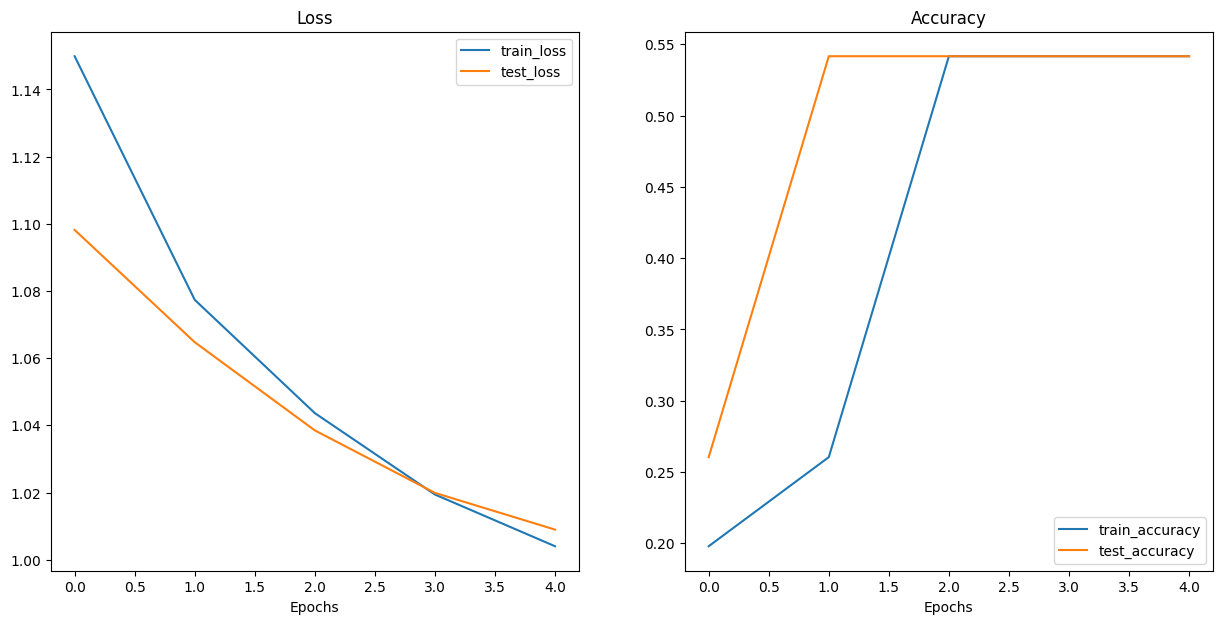

In [50]:
plot_loss_curves(model_0_results)

## 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [51]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test `Dataset`s and `DataLoader`s

In [52]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [53]:
# Turn Datasets into DataLoaders
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f5d1d8b3110>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5cf01edb90>)

### 9.3 Construct and train Model 1

In [54]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)
).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [55]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as Timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')

 20%|██        | 1/5 [00:00<00:03,  1.05it/s]

Epoch: 1 | train_loss: 1.1074 | test_loss: 1.1059 | test_acc: 0.2604


 40%|████      | 2/5 [00:01<00:02,  1.14it/s]

Epoch: 2 | train_loss: 1.0790 | test_loss: 1.1385 | test_acc: 0.2604


 60%|██████    | 3/5 [00:02<00:01,  1.17it/s]

Epoch: 3 | train_loss: 1.0805 | test_loss: 1.1686 | test_acc: 0.2604


 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

Epoch: 4 | train_loss: 1.1286 | test_loss: 1.1625 | test_acc: 0.2604


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

Epoch: 5 | train_loss: 1.0886 | test_loss: 1.1485 | test_acc: 0.2604
Total training time: 4.253 seconds


### 9.4 Plot the loss curves of Model 1

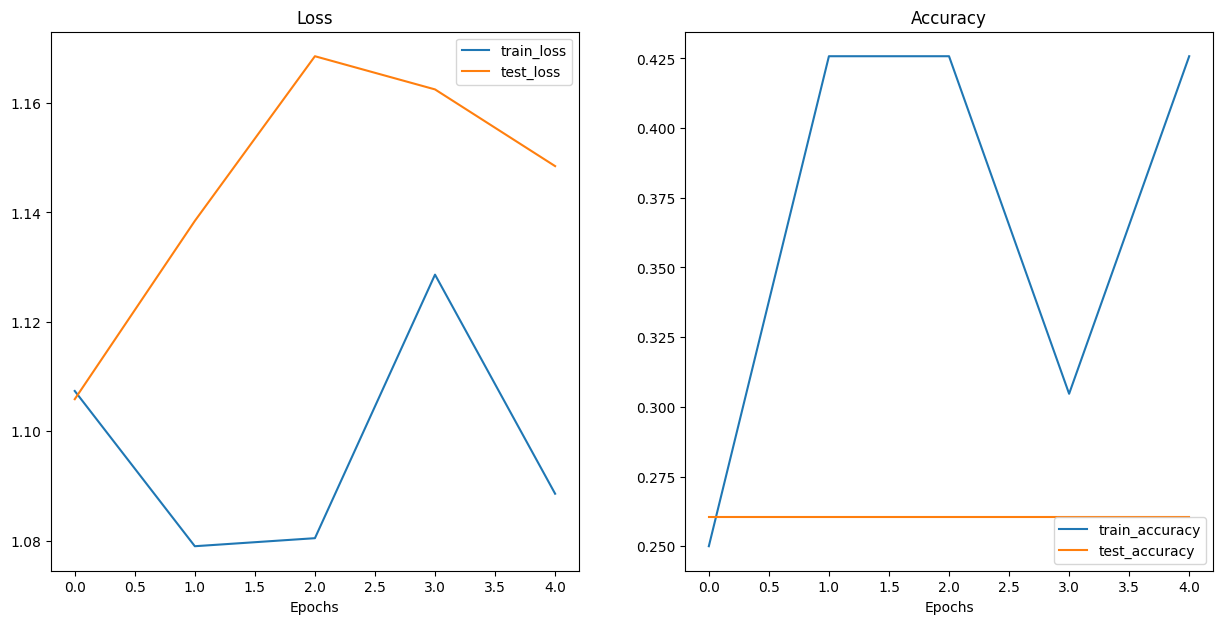

In [56]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [57]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.149900,0.197917,1.098190,0.260417
1,1.077378,0.260417,1.064761,0.541667
2,1.043648,0.541667,1.038508,0.541667
3,1.019414,0.541667,1.019897,0.541667
4,1.004015,0.541667,1.008964,0.541667


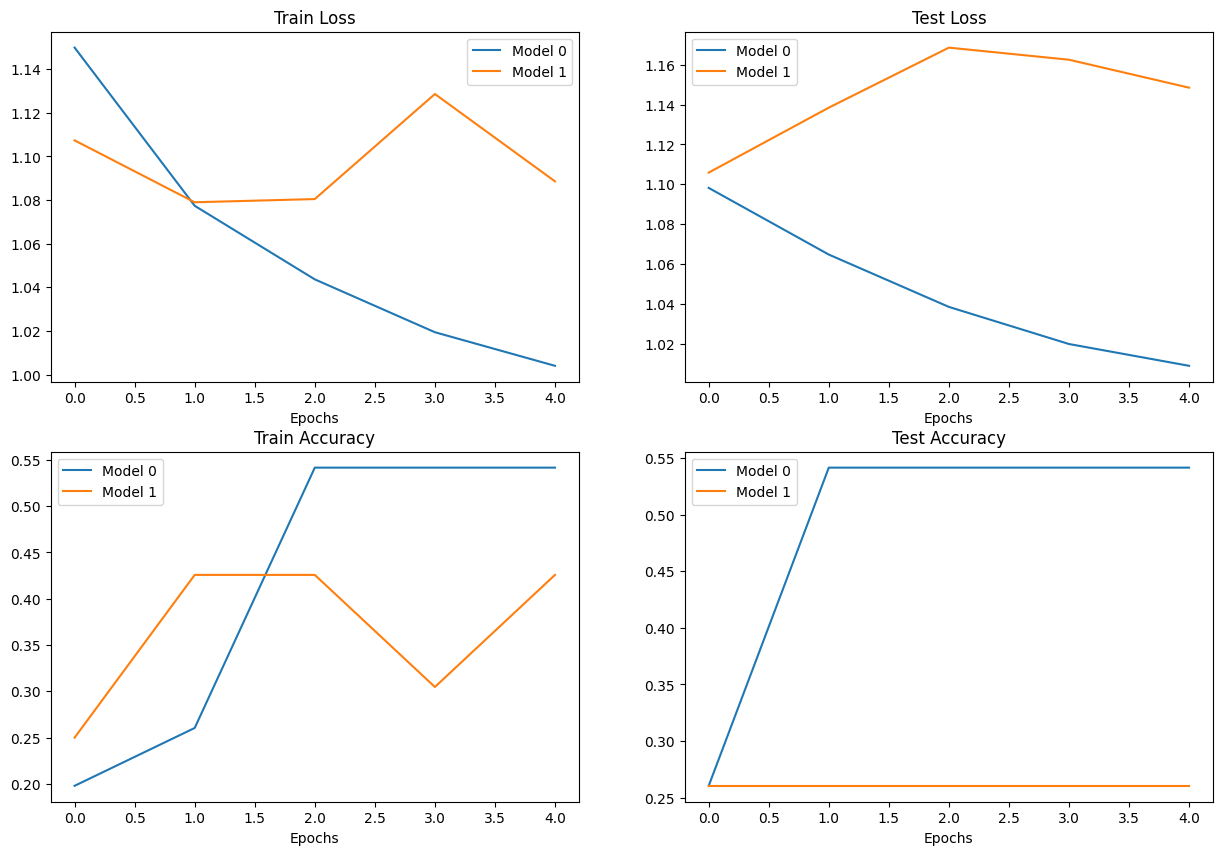

In [58]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Train Accuracy')
plt.xlabel('Epochs')
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.legend();

## 11. Make a prediction on a custom image

In [59]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / '04-pizza-dad.jpeg'

# Download the image if it doesn't already exist

if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f'{custom_image_path} already exists, skipping download.')

data/04-pizza-dad.jpeg already exists, skipping download.


### 11.1 Loading in a custom image with PyTorch

In [60]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f'Custom image tensor:\n{custom_image_uint8}\n')
print(f'Custom image shape: {custom_image_uint8.shape}\n')
print(f'Custom image dtype: {custom_image_uint8.dtype}')

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [61]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [62]:
# Load in custom image and convert the tensor values to float 32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f'Custom image tensor:\n{custom_image}\n')
print(f'Custom image shape: {custom_image.shape}\n')
print(f'Custom image dtype: {custom_image.dtype}')

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### 11.2 Predicting on custom images with a trained PyTorch model

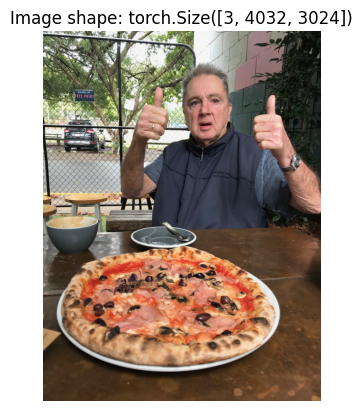

In [63]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimenstions from CHW -> HWC otherwise Matplotlib will error
plt.title(f'Image shape: {custom_image.shape}')
plt.axis(False);

In [64]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f'Original shape: {custom_image.shape}')
print(f'New shape: {custom_image_transformed.shape}')

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


/home/ewan/PyTorch_Practice/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [66]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [67]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f'Custom image transformed shape: {custom_image_transformed.shape}')
    print(f'Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}')

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [68]:
custom_image_pred

tensor([[ 0.1107,  0.0259, -0.1444]], device='cuda:0')

In [69]:
# Print out prediction logits
print(f'Prediction logits: {custom_image_pred}')

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f'Prediction probabilities: {custom_image_pred_probs}')

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f'Prediction label: {custom_image_pred_label}')

Prediction logits: tensor([[ 0.1107,  0.0259, -0.1444]], device='cuda:0')
Prediction probabilities: tensor([[0.3713, 0.3411, 0.2877]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [70]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

In [71]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3713, 0.3411, 0.2877]], device='cuda:0')

### 11.3 Putting custom image prediction together: building a function

In [78]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Covert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for Matplotlib
    if class_names:
        title = f'Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}'
    else:
        title = f'Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}'
    plt.title(title)
    plt.axis(False);

/home/ewan/PyTorch_Practice/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


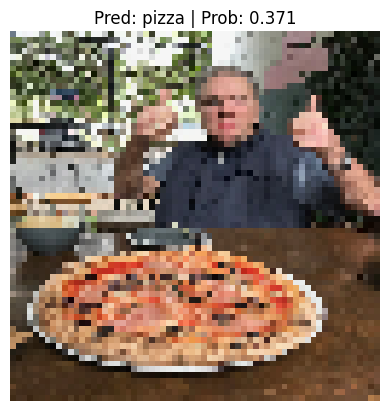

In [79]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

## Exercises

1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

* Add more layers/units to the model.
Increases the capacity of the model to learn patterns in the data.

* Tweak the learning rate
If the learning rate is too high then the model will not learn anything when updating weights (will miss the minimum).

* Train for longer
Gives the model more epochs in which to learn patterns in the data.

2. Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test `DataLoader`'s ready to use.

In [1]:
# Imports
import torch
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on: {device}\n')

# Get train and test directories (will assume data is already on system)
train_dir = Path('data/pizza_steak_sushi/train')
test_dir = Path('data/pizza_steak_sushi/train')

# Write transform for images
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Create datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
 
print(f'Train data:\n{train_data}')
print(f'Test data:\n{test_data}')

# Turn datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

Running on: cpu

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


/home/ewan/PyTorch_Practice/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


(<torch.utils.data.dataloader.DataLoader at 0x7ff469bc9b50>,
 <torch.utils.data.dataloader.DataLoader at 0x7ff469bd0c10>)

3. Recreate model_0 we built in section 7.

In [2]:
# Imports
from torch import nn

# Create CNN based on TinyVGG
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        """
        Initializes all hyperparameters for a multi-class classficication model.
        
        Args:
            input_shape (int): Shape of input data.
            hidden_units (int): Number of hidden units between layers.
            output_shape(int): Shape of output logits.
        """
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

# Create model_0
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

4. Create training and testing functions for model_0.

In [3]:
# Imports
from tqdm.auto import tqdm

# Train loop
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through DataLoader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to taget device
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

# Test loop
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# Combine into train function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # Create empty results dictionary 
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # Loop through training and tetsing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # Print out what's happening
        print(f'Epoch: {epoch+1} | '
              f'train_loss: {train_loss:.4f} | '
              f'test_loss: {test_loss:.4f} | '
              f'test_acc: {test_acc:.4f}')

        # Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

/home/ewan/PyTorch_Practice/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.


In [4]:
# Imports
from timeit import default_timer as timer

# Set number of epochs
LIST_NUM_EPOCHS = [5, 20, 50]
model_0_results = [{}, {}, {}]
# Loop through experiments
for i, num_epochs in enumerate(LIST_NUM_EPOCHS):
    # Set random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Recreate an instance of TinyVGG
    model_0 = TinyVGG(input_shape=3,
                      hidden_units=10,
                      output_shape=len(train_data.classes)).to(device)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

    # Start the timer
    start_time=timer()

    # Train model_0
    model_0_results[i] = train(model=model_0,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimizer,
                            loss_fn=loss_fn,
                            epochs=num_epochs)

    # End the timer and print out how long it took
    end_time = timer()
    print(f'Total training time: {end_time-start_time:.3f} seconds')

 20%|██        | 1/5 [00:01<00:04,  1.11s/it]

Epoch: 1 | train_loss: 1.1177 | test_loss: 1.0989 | test_acc: 0.3467


 40%|████      | 2/5 [00:02<00:03,  1.10s/it]

Epoch: 2 | train_loss: 1.0999 | test_loss: 1.0985 | test_acc: 0.3333


 60%|██████    | 3/5 [00:03<00:02,  1.15s/it]

Epoch: 3 | train_loss: 1.0992 | test_loss: 1.0982 | test_acc: 0.3467


 80%|████████  | 4/5 [00:04<00:01,  1.13s/it]

Epoch: 4 | train_loss: 1.0990 | test_loss: 1.0982 | test_acc: 0.3467


100%|██████████| 5/5 [00:05<00:00,  1.13s/it]


Epoch: 5 | train_loss: 1.0988 | test_loss: 1.0980 | test_acc: 0.3467
Total training time: 5.646 seconds


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

Epoch: 1 | train_loss: 1.1177 | test_loss: 1.0989 | test_acc: 0.3467


 10%|█         | 2/20 [00:02<00:20,  1.12s/it]

Epoch: 2 | train_loss: 1.0999 | test_loss: 1.0985 | test_acc: 0.3333


 15%|█▌        | 3/20 [00:03<00:19,  1.14s/it]

Epoch: 3 | train_loss: 1.0992 | test_loss: 1.0982 | test_acc: 0.3467


 20%|██        | 4/20 [00:04<00:18,  1.14s/it]

Epoch: 4 | train_loss: 1.0990 | test_loss: 1.0982 | test_acc: 0.3467


 25%|██▌       | 5/20 [00:05<00:17,  1.16s/it]

Epoch: 5 | train_loss: 1.0988 | test_loss: 1.0980 | test_acc: 0.3467


 30%|███       | 6/20 [00:06<00:16,  1.15s/it]

Epoch: 6 | train_loss: 1.0989 | test_loss: 1.0975 | test_acc: 0.3467


 35%|███▌      | 7/20 [00:08<00:14,  1.15s/it]

Epoch: 7 | train_loss: 1.0979 | test_loss: 1.0927 | test_acc: 0.4400


 40%|████      | 8/20 [00:09<00:13,  1.12s/it]

Epoch: 8 | train_loss: 1.1028 | test_loss: 1.0919 | test_acc: 0.4311


 45%|████▌     | 9/20 [00:10<00:12,  1.15s/it]

Epoch: 9 | train_loss: 1.0579 | test_loss: 0.9105 | test_acc: 0.5956


 50%|█████     | 10/20 [00:11<00:11,  1.15s/it]

Epoch: 10 | train_loss: 0.9474 | test_loss: 0.8820 | test_acc: 0.5733


 55%|█████▌    | 11/20 [00:12<00:10,  1.13s/it]

Epoch: 11 | train_loss: 0.8914 | test_loss: 0.8013 | test_acc: 0.5911


 60%|██████    | 12/20 [00:13<00:08,  1.12s/it]

Epoch: 12 | train_loss: 0.8066 | test_loss: 0.7436 | test_acc: 0.6756


 65%|██████▌   | 13/20 [00:14<00:08,  1.15s/it]

Epoch: 13 | train_loss: 0.8202 | test_loss: 0.7060 | test_acc: 0.6933


 70%|███████   | 14/20 [00:15<00:06,  1.13s/it]

Epoch: 14 | train_loss: 0.7224 | test_loss: 0.7590 | test_acc: 0.6578


 75%|███████▌  | 15/20 [00:17<00:05,  1.15s/it]

Epoch: 15 | train_loss: 0.7231 | test_loss: 0.6641 | test_acc: 0.7556


 80%|████████  | 16/20 [00:18<00:04,  1.14s/it]

Epoch: 16 | train_loss: 0.6615 | test_loss: 0.5689 | test_acc: 0.7600


 85%|████████▌ | 17/20 [00:19<00:03,  1.13s/it]

Epoch: 17 | train_loss: 0.6408 | test_loss: 0.5060 | test_acc: 0.8222


 90%|█████████ | 18/20 [00:20<00:02,  1.13s/it]

Epoch: 18 | train_loss: 0.5511 | test_loss: 0.5216 | test_acc: 0.7911


 95%|█████████▌| 19/20 [00:21<00:01,  1.12s/it]

Epoch: 19 | train_loss: 0.5838 | test_loss: 0.4466 | test_acc: 0.8133


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Epoch: 20 | train_loss: 0.4886 | test_loss: 0.4046 | test_acc: 0.8311
Total training time: 22.680 seconds


  2%|▏         | 1/50 [00:01<00:52,  1.08s/it]

Epoch: 1 | train_loss: 1.1177 | test_loss: 1.0989 | test_acc: 0.3467


  4%|▍         | 2/50 [00:02<00:56,  1.17s/it]

Epoch: 2 | train_loss: 1.0999 | test_loss: 1.0985 | test_acc: 0.3333


  6%|▌         | 3/50 [00:03<00:53,  1.14s/it]

Epoch: 3 | train_loss: 1.0992 | test_loss: 1.0982 | test_acc: 0.3467


  8%|▊         | 4/50 [00:04<00:52,  1.14s/it]

Epoch: 4 | train_loss: 1.0990 | test_loss: 1.0982 | test_acc: 0.3467


 10%|█         | 5/50 [00:05<00:51,  1.14s/it]

Epoch: 5 | train_loss: 1.0988 | test_loss: 1.0980 | test_acc: 0.3467


 12%|█▏        | 6/50 [00:06<00:51,  1.16s/it]

Epoch: 6 | train_loss: 1.0989 | test_loss: 1.0975 | test_acc: 0.3467


 14%|█▍        | 7/50 [00:08<00:50,  1.17s/it]

Epoch: 7 | train_loss: 1.0979 | test_loss: 1.0927 | test_acc: 0.4400


 16%|█▌        | 8/50 [00:09<00:47,  1.14s/it]

Epoch: 8 | train_loss: 1.1028 | test_loss: 1.0919 | test_acc: 0.4311


 18%|█▊        | 9/50 [00:10<00:47,  1.16s/it]

Epoch: 9 | train_loss: 1.0579 | test_loss: 0.9105 | test_acc: 0.5956


 20%|██        | 10/50 [00:11<00:44,  1.12s/it]

Epoch: 10 | train_loss: 0.9474 | test_loss: 0.8820 | test_acc: 0.5733


 22%|██▏       | 11/50 [00:12<00:45,  1.16s/it]

Epoch: 11 | train_loss: 0.8914 | test_loss: 0.8013 | test_acc: 0.5911


 24%|██▍       | 12/50 [00:13<00:44,  1.17s/it]

Epoch: 12 | train_loss: 0.8066 | test_loss: 0.7436 | test_acc: 0.6756


 26%|██▌       | 13/50 [00:15<00:43,  1.17s/it]

Epoch: 13 | train_loss: 0.8202 | test_loss: 0.7060 | test_acc: 0.6933


 28%|██▊       | 14/50 [00:16<00:42,  1.17s/it]

Epoch: 14 | train_loss: 0.7224 | test_loss: 0.7590 | test_acc: 0.6578


 30%|███       | 15/50 [00:17<00:41,  1.18s/it]

Epoch: 15 | train_loss: 0.7231 | test_loss: 0.6641 | test_acc: 0.7556


 32%|███▏      | 16/50 [00:18<00:38,  1.14s/it]

Epoch: 16 | train_loss: 0.6615 | test_loss: 0.5689 | test_acc: 0.7600


 34%|███▍      | 17/50 [00:19<00:38,  1.15s/it]

Epoch: 17 | train_loss: 0.6408 | test_loss: 0.5060 | test_acc: 0.8222


 36%|███▌      | 18/50 [00:20<00:37,  1.16s/it]

Epoch: 18 | train_loss: 0.5511 | test_loss: 0.5216 | test_acc: 0.7911


 38%|███▊      | 19/50 [00:21<00:35,  1.14s/it]

Epoch: 19 | train_loss: 0.5838 | test_loss: 0.4466 | test_acc: 0.8133


 40%|████      | 20/50 [00:23<00:34,  1.14s/it]

Epoch: 20 | train_loss: 0.4886 | test_loss: 0.4046 | test_acc: 0.8311


 42%|████▏     | 21/50 [00:24<00:32,  1.13s/it]

Epoch: 21 | train_loss: 0.4244 | test_loss: 0.3990 | test_acc: 0.8578


 44%|████▍     | 22/50 [00:25<00:32,  1.15s/it]

Epoch: 22 | train_loss: 0.4168 | test_loss: 0.2900 | test_acc: 0.9067


 46%|████▌     | 23/50 [00:26<00:30,  1.12s/it]

Epoch: 23 | train_loss: 0.4113 | test_loss: 0.2781 | test_acc: 0.9244


 48%|████▊     | 24/50 [00:27<00:29,  1.14s/it]

Epoch: 24 | train_loss: 0.3292 | test_loss: 0.2593 | test_acc: 0.9067


 50%|█████     | 25/50 [00:28<00:28,  1.14s/it]

Epoch: 25 | train_loss: 0.3430 | test_loss: 0.2157 | test_acc: 0.9333


 52%|█████▏    | 26/50 [00:29<00:27,  1.16s/it]

Epoch: 26 | train_loss: 0.2112 | test_loss: 0.2096 | test_acc: 0.9333


 54%|█████▍    | 27/50 [00:31<00:26,  1.14s/it]

Epoch: 27 | train_loss: 0.1737 | test_loss: 0.2699 | test_acc: 0.8889


 56%|█████▌    | 28/50 [00:32<00:24,  1.13s/it]

Epoch: 28 | train_loss: 0.2028 | test_loss: 0.2023 | test_acc: 0.9200


 58%|█████▊    | 29/50 [00:33<00:24,  1.15s/it]

Epoch: 29 | train_loss: 0.1498 | test_loss: 0.1589 | test_acc: 0.9378


 60%|██████    | 30/50 [00:34<00:22,  1.13s/it]

Epoch: 30 | train_loss: 0.2078 | test_loss: 0.1935 | test_acc: 0.9467


 62%|██████▏   | 31/50 [00:35<00:21,  1.13s/it]

Epoch: 31 | train_loss: 0.1546 | test_loss: 0.1491 | test_acc: 0.9467


 64%|██████▍   | 32/50 [00:36<00:20,  1.12s/it]

Epoch: 32 | train_loss: 0.1434 | test_loss: 0.1220 | test_acc: 0.9556


 66%|██████▌   | 33/50 [00:37<00:19,  1.15s/it]

Epoch: 33 | train_loss: 0.1598 | test_loss: 0.1157 | test_acc: 0.9689


 68%|██████▊   | 34/50 [00:38<00:18,  1.13s/it]

Epoch: 34 | train_loss: 0.0815 | test_loss: 0.0517 | test_acc: 0.9956


 70%|███████   | 35/50 [00:40<00:16,  1.12s/it]

Epoch: 35 | train_loss: 0.0496 | test_loss: 0.0922 | test_acc: 0.9733


 72%|███████▏  | 36/50 [00:41<00:16,  1.15s/it]

Epoch: 36 | train_loss: 0.0606 | test_loss: 0.0263 | test_acc: 0.9956


 74%|███████▍  | 37/50 [00:42<00:15,  1.16s/it]

Epoch: 37 | train_loss: 0.1042 | test_loss: 0.1329 | test_acc: 0.9600


 76%|███████▌  | 38/50 [00:43<00:13,  1.17s/it]

Epoch: 38 | train_loss: 0.0523 | test_loss: 0.0298 | test_acc: 0.9867


 78%|███████▊  | 39/50 [00:44<00:12,  1.13s/it]

Epoch: 39 | train_loss: 0.0777 | test_loss: 0.0319 | test_acc: 0.9867


 80%|████████  | 40/50 [00:45<00:11,  1.13s/it]

Epoch: 40 | train_loss: 0.0199 | test_loss: 0.0294 | test_acc: 1.0000


 82%|████████▏ | 41/50 [00:46<00:10,  1.12s/it]

Epoch: 41 | train_loss: 0.0685 | test_loss: 0.0454 | test_acc: 0.9867


 84%|████████▍ | 42/50 [00:48<00:09,  1.16s/it]

Epoch: 42 | train_loss: 0.0244 | test_loss: 0.0160 | test_acc: 0.9956


 86%|████████▌ | 43/50 [00:49<00:07,  1.13s/it]

Epoch: 43 | train_loss: 0.0200 | test_loss: 0.0087 | test_acc: 1.0000


 88%|████████▊ | 44/50 [00:50<00:06,  1.14s/it]

Epoch: 44 | train_loss: 0.0102 | test_loss: 0.0077 | test_acc: 1.0000


 90%|█████████ | 45/50 [00:51<00:05,  1.12s/it]

Epoch: 45 | train_loss: 0.0118 | test_loss: 0.0163 | test_acc: 0.9956


 92%|█████████▏| 46/50 [00:52<00:04,  1.11s/it]

Epoch: 46 | train_loss: 0.0078 | test_loss: 0.0080 | test_acc: 1.0000


 94%|█████████▍| 47/50 [00:53<00:03,  1.15s/it]

Epoch: 47 | train_loss: 0.0063 | test_loss: 0.0047 | test_acc: 1.0000


 96%|█████████▌| 48/50 [00:54<00:02,  1.16s/it]

Epoch: 48 | train_loss: 0.0041 | test_loss: 0.0033 | test_acc: 1.0000


 98%|█████████▊| 49/50 [00:56<00:01,  1.13s/it]

Epoch: 49 | train_loss: 0.0036 | test_loss: 0.0021 | test_acc: 1.0000


100%|██████████| 50/50 [00:57<00:00,  1.14s/it]

Epoch: 50 | train_loss: 0.0015 | test_loss: 0.0021 | test_acc: 1.0000
Total training time: 57.134 seconds


With 5 epochs test accuracy is 34.67%. With 20 epochs test accuracy is 83.11%. With 50 epochs test accuracy goes up to 100%. As the numbewr of epochs increases, the test accuracy increases, and the train and test losses decrease.

6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [5]:
# Set manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG with double the hidden units
model_1 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} s')

  5%|▌         | 1/20 [00:01<00:27,  1.46s/it]

Epoch: 1 | train_loss: 1.0979 | test_loss: 1.0978 | test_acc: 0.3467


 10%|█         | 2/20 [00:02<00:24,  1.39s/it]

Epoch: 2 | train_loss: 1.0615 | test_loss: 1.0174 | test_acc: 0.5333


 15%|█▌        | 3/20 [00:04<00:23,  1.36s/it]

Epoch: 3 | train_loss: 1.0057 | test_loss: 0.9129 | test_acc: 0.5600


 20%|██        | 4/20 [00:05<00:21,  1.36s/it]

Epoch: 4 | train_loss: 0.9210 | test_loss: 0.8566 | test_acc: 0.6489


 25%|██▌       | 5/20 [00:06<00:20,  1.36s/it]

Epoch: 5 | train_loss: 0.8961 | test_loss: 0.8577 | test_acc: 0.6311


 30%|███       | 6/20 [00:08<00:18,  1.35s/it]

Epoch: 6 | train_loss: 0.8714 | test_loss: 0.8331 | test_acc: 0.6622


 35%|███▌      | 7/20 [00:09<00:17,  1.37s/it]

Epoch: 7 | train_loss: 0.8502 | test_loss: 0.7870 | test_acc: 0.6756


 40%|████      | 8/20 [00:10<00:16,  1.38s/it]

Epoch: 8 | train_loss: 0.8227 | test_loss: 0.7510 | test_acc: 0.7022


 45%|████▌     | 9/20 [00:12<00:15,  1.38s/it]

Epoch: 9 | train_loss: 0.7595 | test_loss: 0.7475 | test_acc: 0.6711


 50%|█████     | 10/20 [00:13<00:13,  1.40s/it]

Epoch: 10 | train_loss: 0.7125 | test_loss: 0.6531 | test_acc: 0.7289


 55%|█████▌    | 11/20 [00:15<00:12,  1.40s/it]

Epoch: 11 | train_loss: 0.6942 | test_loss: 0.6400 | test_acc: 0.7600


 60%|██████    | 12/20 [00:16<00:11,  1.39s/it]

Epoch: 12 | train_loss: 0.6348 | test_loss: 0.6247 | test_acc: 0.7511


 65%|██████▌   | 13/20 [00:17<00:09,  1.39s/it]

Epoch: 13 | train_loss: 0.5690 | test_loss: 0.4738 | test_acc: 0.8044


 70%|███████   | 14/20 [00:19<00:08,  1.39s/it]

Epoch: 14 | train_loss: 0.5912 | test_loss: 0.4715 | test_acc: 0.7956


 75%|███████▌  | 15/20 [00:20<00:06,  1.39s/it]

Epoch: 15 | train_loss: 0.4866 | test_loss: 0.4027 | test_acc: 0.8311


 80%|████████  | 16/20 [00:22<00:05,  1.40s/it]

Epoch: 16 | train_loss: 0.4056 | test_loss: 0.3104 | test_acc: 0.8844


 85%|████████▌ | 17/20 [00:23<00:04,  1.41s/it]

Epoch: 17 | train_loss: 0.4426 | test_loss: 0.3480 | test_acc: 0.8667


 90%|█████████ | 18/20 [00:25<00:02,  1.41s/it]

Epoch: 18 | train_loss: 0.3090 | test_loss: 0.2792 | test_acc: 0.8978


 95%|█████████▌| 19/20 [00:26<00:01,  1.40s/it]

Epoch: 19 | train_loss: 0.2657 | test_loss: 0.1637 | test_acc: 0.9422


100%|██████████| 20/20 [00:27<00:00,  1.39s/it]

Epoch: 20 | train_loss: 0.2144 | test_loss: 0.1352 | test_acc: 0.9467
Total training time: 27.750 s


With double the hidden units the test accuracy goes to 94.67%. Increasing the number of hidden units has increased the test accuracy and decreased the train and test losses.

7. Double the data you're using with your model and train it for 20 epochs, what happens to the results?
* **Note**: You can use the custom data creation notebook to scale up your Food101 dataset.
* You can also find the already formatted double data (20% instead of 10% subset) dataset on GitHub, you will need to write download code like in exercise 2 to get it into this notebook.


In [6]:
# Imports
import requests
import zipfile

### Download dataset
# Setup path to data folder
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi_20/'

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f'{image_path} directory exists.')
else:
    print(f'Did not find {image_path} directory, creating one...')
    image_path.mkdir(parents=True, exist_ok=True)

    # Download 20% subset
    with open(data_path / 'pizza_steak_sushi_20.zip', 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip')
        print('Downloading pizza, steak, sushi data...')
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / 'pizza_steak_sushi_20.zip', 'r') as zip_ref:
        print('Unzipping pizza, steak, sushi data...')
        zip_ref.extractall(image_path)

### Prepare DataLoaders
# Setup paths to train and test folders
train_dir_20 = image_path / 'train'
test_dir_20 = image_path / 'test'

# Create datasets
train_data_20 = datasets.ImageFolder(root=train_dir_20,
                                     transform=data_transform,
                                     target_transform=None)

test_data_20 = datasets.ImageFolder(root=test_dir_20,
                                    transform=data_transform)

print(f'Train data:\n{train_data_20}\n')
print(f'Test data:\n{test_data_20}\n')

# Turn datasets into DataLoaders
train_dataloader_20 = DataLoader(dataset=train_data_20,
                                 batch_size=1,
                                 num_workers=1,
                                 shuffle=True)

test_dataloader_20 = DataLoader(dataset=test_data_20,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

print(train_dataloader, test_dataloader)

### Train and evaluate model_2
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Create model_2
model_2 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(train_data_20.classes)).to(device)
                  
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Trian model_2
model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader_20,
                        test_dataloader=test_dataloader_20,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} s')

data/pizza_steak_sushi_20 directory exists.
Train data:
Dataset ImageFolder
    Number of datapoints: 450
    Root location: data/pizza_steak_sushi_20/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

Test data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: data/pizza_steak_sushi_20/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

<torch.utils.data.dataloader.DataLoader object at 0x7ff469bc9b50> <torch.utils.data.dataloader.DataLoader object at 0x7ff469bd0c10>


  5%|▌         | 1/20 [00:02<00:38,  2.01s/it]

Epoch: 1 | train_loss: 1.0957 | test_loss: 1.2296 | test_acc: 0.3867


 10%|█         | 2/20 [00:03<00:35,  2.00s/it]

Epoch: 2 | train_loss: 1.0169 | test_loss: 0.9502 | test_acc: 0.6133


 15%|█▌        | 3/20 [00:05<00:33,  1.95s/it]

Epoch: 3 | train_loss: 0.9182 | test_loss: 0.8909 | test_acc: 0.6067


 20%|██        | 4/20 [00:07<00:31,  1.96s/it]

Epoch: 4 | train_loss: 0.9036 | test_loss: 0.8551 | test_acc: 0.6400


 25%|██▌       | 5/20 [00:09<00:29,  1.96s/it]

Epoch: 5 | train_loss: 0.8725 | test_loss: 0.8951 | test_acc: 0.6067


 30%|███       | 6/20 [00:11<00:27,  1.99s/it]

Epoch: 6 | train_loss: 0.8161 | test_loss: 0.8932 | test_acc: 0.5600


 35%|███▌      | 7/20 [00:13<00:25,  1.98s/it]

Epoch: 7 | train_loss: 0.7914 | test_loss: 0.9584 | test_acc: 0.6067


 40%|████      | 8/20 [00:15<00:23,  1.98s/it]

Epoch: 8 | train_loss: 0.7551 | test_loss: 0.8230 | test_acc: 0.6533


 45%|████▌     | 9/20 [00:17<00:21,  1.99s/it]

Epoch: 9 | train_loss: 0.7113 | test_loss: 0.9131 | test_acc: 0.6400


 50%|█████     | 10/20 [00:19<00:19,  1.98s/it]

Epoch: 10 | train_loss: 0.7220 | test_loss: 0.8396 | test_acc: 0.6400


 55%|█████▌    | 11/20 [00:21<00:17,  1.96s/it]

Epoch: 11 | train_loss: 0.6456 | test_loss: 0.8312 | test_acc: 0.6933


 60%|██████    | 12/20 [00:23<00:15,  1.98s/it]

Epoch: 12 | train_loss: 0.5884 | test_loss: 0.8592 | test_acc: 0.6733


 65%|██████▌   | 13/20 [00:25<00:13,  1.99s/it]

Epoch: 13 | train_loss: 0.5420 | test_loss: 0.9368 | test_acc: 0.6333


 70%|███████   | 14/20 [00:27<00:11,  1.98s/it]

Epoch: 14 | train_loss: 0.5138 | test_loss: 0.9170 | test_acc: 0.6400


 75%|███████▌  | 15/20 [00:29<00:09,  1.98s/it]

Epoch: 15 | train_loss: 0.4631 | test_loss: 0.9820 | test_acc: 0.6600


 80%|████████  | 16/20 [00:31<00:07,  2.00s/it]

Epoch: 16 | train_loss: 0.4418 | test_loss: 1.0940 | test_acc: 0.6200


 85%|████████▌ | 17/20 [00:33<00:05,  1.98s/it]

Epoch: 17 | train_loss: 0.3706 | test_loss: 1.0532 | test_acc: 0.6467


 90%|█████████ | 18/20 [00:35<00:03,  1.98s/it]

Epoch: 18 | train_loss: 0.3619 | test_loss: 1.2147 | test_acc: 0.6733


 95%|█████████▌| 19/20 [00:37<00:01,  2.00s/it]

Epoch: 19 | train_loss: 0.3660 | test_loss: 1.3726 | test_acc: 0.5733


100%|██████████| 20/20 [00:39<00:00,  1.99s/it]

Epoch: 20 | train_loss: 0.3001 | test_loss: 1.3331 | test_acc: 0.6000
Total training time: 39.880 s


Model appears to be overfitting when given more data to train on.

Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

/home/ewan/PyTorch_Practice/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


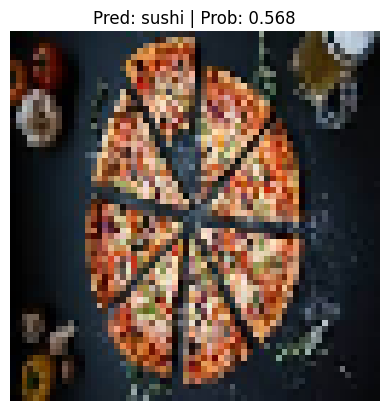

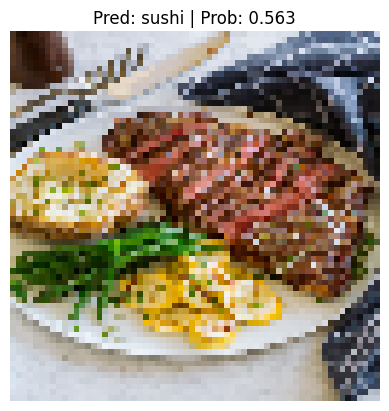

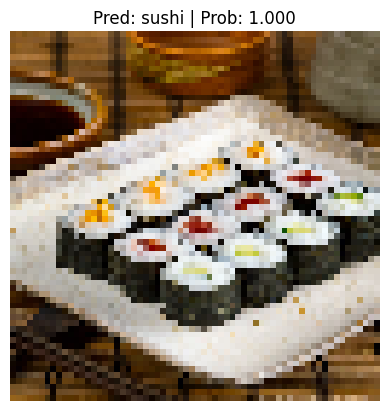

In [12]:
# Imports
import matplotlib.pyplot as plt
import torchvision
from typing import List

# Load in, predict and plot image (using function from before)
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    # Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Covert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for Matplotlib
    if class_names:
        title = f'Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}'
    else:
        title = f'Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}'
    plt.title(title)
    plt.axis(False);

# Image paths
pizza_path = data_path / 'pizza.jpeg'
steak_path = data_path / 'steak.jpg'
sushi_path = data_path / 'sushi.jpg'

# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

# Grab class names
class_names = train_data.classes

# Predict on custom images
pred_and_plot_image(model=model_2,
                    image_path=pizza_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)
plt.show()
pred_and_plot_image(model=model_2,
                    image_path=steak_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)
plt.show()
pred_and_plot_image(model=model_2,
                    image_path=sushi_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)
plt.show();